# 1. Data Augmentation  
**Authors:** _Gustav Christensen and Christoffer Kramer_

We decided to use data augmentation to make our model more generalizable. We also shuffled the image order to avoid any potential bias in the image order. We created a function called _generate_data_ which returned four _ImageDataGenerators_. We did this, since it would make it a lot easier to implement different models in different files while still ensuring that the input data received the same type of data augmentation.

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import clone_model
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt
from math import ceil
from os import listdir
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import os
import numpy as np


def generate_data(targ_size, batch_size):
    """
    Creates datagenerators with the specified target dimensions and batch sizes
    """
    # ------ Training data ------
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        rotation_range = 20,
        width_shift_range = 0.20,
        height_shift_range = 0.20,
        shear_range=0.10,
        zoom_range=0.20,
        horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        directory = r"catdog_data/train",
        target_size = targ_size,
        color_mode = "rgb",
        batch_size = batch_size,
        class_mode='binary',
        shuffle = True) 

    # ------ Test data ------
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_val_datagen.flow_from_directory(
        directory= r"catdog_data/test",
        target_size = targ_size,
        color_mode="rgb",
        batch_size = batch_size,
        class_mode= "binary")

    # ------ Validation data ------
    val_generator = test_val_datagen.flow_from_directory( 
        directory = r"catdog_data/validation",
        target_size = targ_size,
        color_mode = "rgb",
        batch_size= batch_size,
        class_mode='binary')

    # Full training data set
    full_train_generator = train_datagen.flow_from_directory(
        directory = r"catdog_data/train_val",
        target_size = targ_size,
        color_mode = "rgb",
        batch_size = batch_size,
        class_mode='binary',
        shuffle = True)

    return train_generator, val_generator, test_generator, full_train_generator


Since we used augmented data, we needed to make sure that our model wouldn't train indefinitely. We, therefore, created a function for calculating steps per epoch. This caused problems in the beginning of our project since it by mistake returned a step size of 1. This caused our models to fluctuate wildly in their accuracies. However, we fixed this and ended up with some models, which were a lot more stable.

In [23]:
def calc_steps_epoch(n_samples, batch_size, factor):
    """
    Return how many steps to go through in each epoch
    This is neccesarry since we use augmented data
    """
    return int(ceil( (factor * n_samples) / batch_size)) 

For a quick sanity check we loaded an images and inspected how the augmentation looked. We deemed the current augmentation perfect for our taks at hand, since it was comprehensible to us.

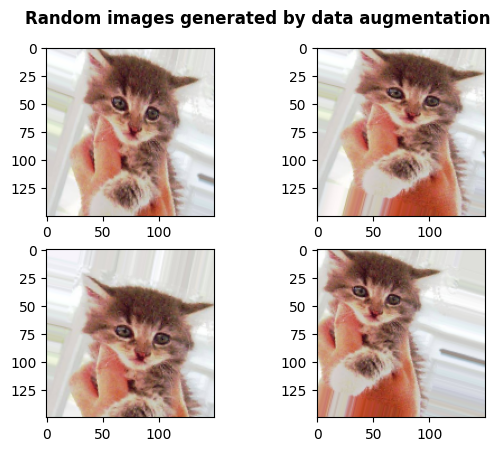

In [24]:
# Datagenerator - Example
datagen = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.20,
        height_shift_range = 0.20,
        shear_range = 0.10,
        zoom_range = 0.20,
        horizontal_flip = True)

fnames = [os.path.join("catdog_data/train/cats/", fname) for
     fname in os.listdir("catdog_data/train/cats/")]

img_path = fnames[3]

img = tf.keras.utils.load_img(img_path, target_size=(150, 150))

x = tf.keras.utils.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    #plt.figure(i)
    ax = plt.subplot(2, 2, i + 1)
    imgplot = plt.imshow(tf.keras.utils.img_to_array(batch[0]).astype(np.uint8))
    i += 1
    if i % 4 == 0:
        break

plt.suptitle("Random images generated by data augmentation", fontweight = "bold", y = 0.96)
plt.show()

# 2. Network Architecture  

**Author:** _Christoffer Kramer_  

We experimented with the following model architectures. The number in parenthesis in convolutional layers refers to the filters/channels:   

**Model 1:**  
* _Hyperparameters_:
  * kernels = (3, 3)
  * Activation = relu
  * Learning Rate = 0.001
* _Architecture_
  * Conv(32) --> MaxPool
  * Conv(64) --> MaxPool
  * Conv(64) --> MaxPool
  * Flatten --> Dense(64)
  * Dropout(0.2) -> Sigmoid  

**Model 2:**
* _Hyperparameters_:
  * kernels = (3, 3)
  * Activation = relu
  * Learning Rate = 0.001
* _Architecture_
  * Conv(32) --> MaxPool
  * Conv(64) --> MaxPool
  * Conv(64) --> MaxPool
  * Conv(64) --> MaxPool
  * Flatten --> Dense(248)
  * Dropout(0.2) -> Sigmoid   

**Model 3:**  
* _Hyperparameters_:
  * kernels = (3, 3)
  * Activation = relu
  * Learning Rate = 0.001
* _Architecture_
  * Conv(32) --> MaxPool
  * Conv(64) --> MaxPool
  * Conv(128) --> MaxPool
  * Flatten --> Dense(128)
  * Dropout(0.2) -> Sigmoid  

We started by training each model for 20 epochs. We used a input shape of 112x112 pixels with three (RGB) color channels. We then choose the most promising model for further training and tweaking. We decided to use model 2, since it was computationally inexpensive, didn’t really overfit and had an accuracy of over 70%. We tweaked it by lowering the batch size to 32 to see if we would get a smoother loss function. This didn't work, so we kept a batch size of 64 but lowered the learning rate of the Adam optimizer to 0.0001. This worked surprisingly well and made the loss function decrease more smoothly and the accuracy likewise increased more smoothly. Since the model didn’t appear to be overfitting, we decided to use these parameters for our final model.


In [25]:
INPUT_SHAPE = (112, 112, 3)
BATCH_SIZE = 64

# Calcualte length of data 
n_train_samples = (len(listdir("catdog_data/train/cats")) + len(listdir("catdog_data/train/dogs")))

n_val_samples = (len(listdir("catdog_data/validation/cats")) + len(listdir("catdog_data/validation/dogs")))

n_test_samples = (len(listdir("catdog_data/test/cats")) + len(listdir("catdog_data/test/dogs")))
                  
n_full_train_samples = n_train_samples + n_val_samples

TEST_STEPS = calc_steps_epoch(n_samples = n_test_samples,
                               batch_size = BATCH_SIZE,
                               factor = 1)

FULL_TRAIN_STEPS = calc_steps_epoch(n_samples = n_full_train_samples,
                               batch_size = BATCH_SIZE,
                               factor = 1)
train_generator, val_generator, test_generator, full_train_generator = generate_data(targ_size = (INPUT_SHAPE[0], INPUT_SHAPE[1]),
                                                                                     batch_size = BATCH_SIZE)

# Model 2
model = models.Sequential()

# Conv(32) -> MaxPool -->
model.add(layers.Conv2D(filters = 32,
                        kernel_size = (3, 3),
                        input_shape = INPUT_SHAPE))
model.add(layers.MaxPooling2D(pool_size = 2))

# Conv(64) -> MaxPool -->
model.add(layers.Conv2D(filters = 64,
                        kernel_size = (3, 3),
                        activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2))

# Conv(64) -> MaxPool -->
model.add(layers.Conv2D(filters = 64,
                        kernel_size = (3, 3),
                        activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2))

# Conv(64) -> MaxPool -->
model.add(layers.Conv2D(filters = 64,
                        kernel_size = (3, 3),
                        activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2))

# Flatten -> Dense(248) -->
model.add(layers.Flatten())
model.add(layers.Dense(248, activation='relu'))

# Dropout(0.2) -> Sigmoid
layers.Dropout(.2)
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss = 'binary_crossentropy',
                      optimizer = optimizers.Adam(learning_rate = 0.0001),
                      metrics = ['accuracy'])


Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


# 3. Visualization
**Author** _Gustav Christensen_

To visualize the training and validation metrics during different epochs, we define a function that takes a fitted model as the only argument.

In [26]:
def plot_hist(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    figure, axis = plt.subplots(2, 1)

    axis[0].plot(epochs, acc, label = 'Training accuracy')
    axis[0].plot(epochs, val_acc, label = 'Validation accuracy')
    axis[0].set_title('Training and validation accuracy')
    axis[0].legend(loc = "lower right")

    axis[1].plot(epochs, loss, label = 'Training loss')
    axis[1].plot(epochs, val_loss, label = 'Training loss')
    axis[1].set_title('Training and validation loss')
    axis[1].legend(loc = "upper right")

    plt.subplots_adjust(hspace = 0.4)

    plt.show()


In [27]:
TRAIN_STEPS = calc_steps_epoch(n_samples = n_train_samples,
                               batch_size = BATCH_SIZE,
                               factor = 1)

VAL_STEPS = calc_steps_epoch(n_samples = n_val_samples,
                               batch_size = BATCH_SIZE,
                               factor = 1)
history = model.fit(
    train_generator,
    steps_per_epoch = TRAIN_STEPS, # 
    epochs = 100,
    validation_data = val_generator,
    validation_steps = VAL_STEPS,
    verbose = True
)

Epoch 1/100
32/32 [==============================] - 25s 740ms/step - loss: 0.6911 - accuracy: 0.5260 - val_loss: 0.6877 - val_accuracy: 0.6133
Epoch 2/100
32/32 [==============================] - 22s 692ms/step - loss: 0.6832 - accuracy: 0.5805 - val_loss: 0.6847 - val_accuracy: 0.5217
Epoch 3/100
32/32 [==============================] - 22s 691ms/step - loss: 0.6782 - accuracy: 0.5655 - val_loss: 0.6766 - val_accuracy: 0.5900
Epoch 4/100
32/32 [==============================] - 22s 693ms/step - loss: 0.6674 - accuracy: 0.6035 - val_loss: 0.6664 - val_accuracy: 0.6033
Epoch 5/100
32/32 [==============================] - 22s 697ms/step - loss: 0.6661 - accuracy: 0.5925 - val_loss: 0.6768 - val_accuracy: 0.5817
Epoch 6/100
32/32 [==============================] - 24s 753ms/step - loss: 0.6598 - accuracy: 0.6100 - val_loss: 0.6694 - val_accuracy: 0.5883
Epoch 7/100
32/32 [==============================] - 24s 742ms/step - loss: 0.6509 - accuracy: 0.6225 - val_loss: 0.6659 - val_accuracy:

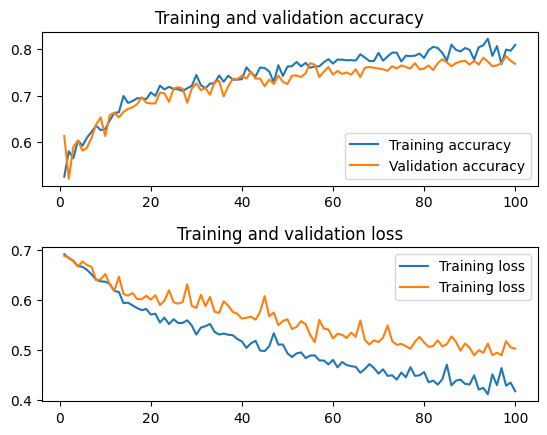

In [28]:
plot_hist(history)

In the figure above, we have plotted the accuracy and loss of both the training and validation set. Here, we observe that both curves for each plot follow the other relatively close which is an indication that the trained neural network is not overfitting. Therefore, the model is ready for training on the full data set.

# 4. Final Results  
**Authors:** _Gustav Christensen and Christoffer Kramer_  

For the final model we trained on both the training and validation set, we used epoch 100 and early stopping with a patience of 7.

In [32]:
clear_session()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
final_model = clone_model(model)
final_model.compile(loss = 'binary_crossentropy',
                      optimizer = optimizers.Adam(learning_rate = 0.0001),
                      metrics = ['accuracy'])
                      
final_model.fit(
    full_train_generator,
    steps_per_epoch =  FULL_TRAIN_STEPS,
    epochs = 100,
    verbose = True,
    callbacks=[callback]
)
final_model.evaluate(test_generator, steps = TEST_STEPS)
final_model.save("models/final_model.h5")

Epoch 1/100
41/41 [==============================] - 31s 741ms/step - loss: 0.6912 - accuracy: 0.5169
Epoch 2/100
41/41 [==============================] - 27s 651ms/step - loss: 0.6867 - accuracy: 0.5600
Epoch 3/100
41/41 [==============================] - 27s 648ms/step - loss: 0.6807 - accuracy: 0.5665
Epoch 4/100
41/41 [==============================] - 27s 655ms/step - loss: 0.6778 - accuracy: 0.5558
Epoch 5/100
41/41 [==============================] - 27s 660ms/step - loss: 0.6656 - accuracy: 0.6000
Epoch 6/100
41/41 [==============================] - 27s 653ms/step - loss: 0.6632 - accuracy: 0.5938
Epoch 7/100
41/41 [==============================] - 27s 657ms/step - loss: 0.6594 - accuracy: 0.6023
Epoch 8/100
41/41 [==============================] - 27s 649ms/step - loss: 0.6418 - accuracy: 0.6227
Epoch 9/100
41/41 [==============================] - 27s 645ms/step - loss: 0.6305 - accuracy: 0.6473
Epoch 10/100
41/41 [==============================] - 27s 646ms/step - loss: 0.634

We trained the model for 100 epochs and the accuracy on the test data was 77.25 % which we deemed sufficient.